In [11]:
import sympy
sympy.init_printing()
%matplotlib inline

Fourier series
=========

We can approximate a periodic function of period P to arbitrary accuracy by adding sine and cosine terms (disguised via the Euler formula in the complex exponential): 

$$ S_N(t) = \sum_{n=-N}^N c_n \exp \left( \frac{i 2\pi n t}{P}\right) $$ 

with 

$$ c_n = \frac{1}{P} \int_{t_0}^{t_0 + P} f(t) \exp \left( \frac{-i 2\pi n t}{P}\right) $$

The following two functions attempt to match the notation above as closely as possible using sympy functions

In [295]:
i2pi = sympy.I*2*sympy.pi
exp = sympy.exp

In [296]:
def S(N):
    return sum(c(n)*exp(i2pi*n*t/P) for n in range(-N, N+1)).expand(complex=True).simplify()

In [297]:
def c(n):
    return (sympy.integrate(
               f(t)*exp((-i2pi * n * t)/P), 
               (t, t0, t0 + P))/P)

These functions work quite well for a periodic sawtooth function:

In [298]:
def f(t):
    return t

In [299]:
P = 20
t0 = -10

In [300]:
t = sympy.Symbol('t', real=True)

In [301]:
N = 4

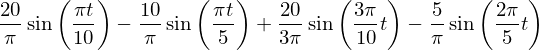

In [302]:
S(N).expand()

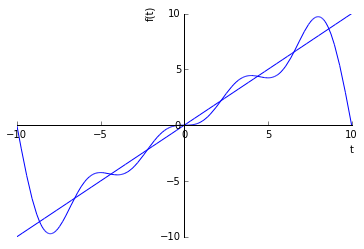

In [303]:
sympy.plot(f(t), S(N), (t, t0, t0+P))

Unfortunately, this notationally elegant approach does not appear to work for `f = sympy.Heaviside`, and is also quite slow. The `sympy.mpmath` library supplies a numeric equivalent.

In [304]:
import sympy.mpmath

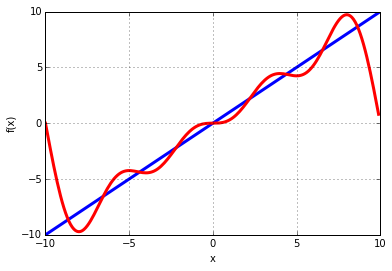

In [305]:
cs = sympy.mpmath.fourier(f, [t0, t0+P], N)

def approx(t):
    return sympy.mpmath.fourierval(cs, [t0, t0+P], t)

sympy.mpmath.plot([f, approx], [t0, t0+P])

The coefficients returned by the `sympy.mpmath.fourier` functions are for the cosine and sine terms in this alternate representation of $S_N$

$$s_N(x) = \sum_{n=0}^N \left(a_n \cos\left(\frac{2\pi nx}{P}\right) + b_n \sin\left(\frac{2\pi nx}{P}\right)\right)$$



We can see the similarity clearly by showing the expression we obtained before multiplied out and numerically evaluated

In [306]:
cs

([mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0'), mpf('0.0')],
 [mpf('0.0'),
  mpf('6.366197723675814'),
  mpf('-3.183098861837907'),
  mpf('2.1220659078919377'),
  mpf('-1.5915494309189535')])

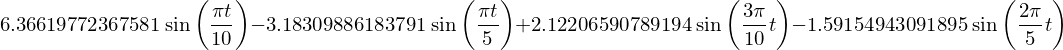

In [307]:
sympy.N(S(N).expand())

Notice that all the cosine coefficients are zero. This is true in general for odd functions.

Step function
------------
Let's now switch to the Heaviside step and draw the various sinusoids in the approximation more explicitly.

In [385]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [386]:
N = 10

In [387]:
@numpy.vectorize
def f(t):
    if t < 0:
        return 0
    else:
        return 1

In [388]:
cs = sympy.mpmath.fourier(f, [t0, t0+P], N)
cs

([mpf('0.5'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0')],
 [mpf('0.0'),
  mpf('0.63675856242795037'),
  mpf('0.0002778345608862911'),
  mpf('0.21262398013873579'),
  mpf('0.00055771310594110598'),
  mpf('0.12802302327076248'),
  mpf('0.00084172518315335683'),
  mpf('0.091931640154520794'),
  mpf('0.0011320535572161288'),
  mpf('0.072015836887865267'),
  mpf('0.0014310262052054015')])

We see that all the cosine terms but the first are zero, so the first cosine coefficient represents a constant being added to the sine series.

In [390]:
constant = cs[0][0]
sinecoefficients = cs[1]

In [391]:
sines = [an*numpy.sin(2*numpy.pi*n*tt/P) for n, an in enumerate(sinecoefficients)]

In [392]:
tt = numpy.linspace(t0, t0 + P, 1000)

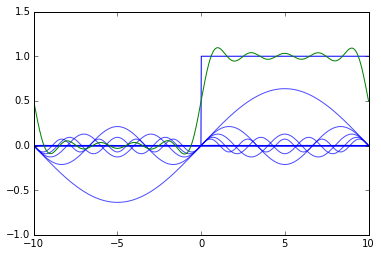

In [393]:
plt.plot(tt, f(tt))
for curve in sines:
    plt.plot(tt, curve, color='blue', alpha=0.7)
plt.plot(tt, sum(sines) + constant)

We can see that the sum of the sines approximates the step function.

Step response via Frequency response
=================

Let's calculate the step response of a second order system in a new way by using the frequency response of the transfer function and the Fourier series of the step input.

In [316]:
s = sympy.Symbol('s')

In [339]:
tau = 1
zeta = sympy.Rational(1, 2)

In [340]:
G = 1/(tau**2*s**2 + 2*tau*zeta*s + 1)
g = sympy.inverse_laplace_transform(G/s, s, t)

This next cell takes a long time to complete, but it is the only way I have found to get a workable numeric list to plot the output.

In [351]:
gtvalues = [complex(g.subs({t: thist})).real for thist in tt]

We can see the familiar second order step response:

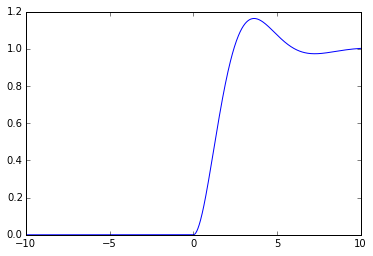

In [395]:
plt.plot(tt, gtvalues)

Now, let's try to get the same answer by exploiting the frequency response of the transfer function. First, we need a function which can evaluate the transfer function at particular values and return a numeric result:

In [396]:
Geval = sympy.lambdify(s, G)

Now, we need to build an array for the frequencies of the Fourier series. Remember we had terms of the form $\sin\left(\frac{2\pi n t}{P}\right) = \sin(\omega t)$ in the Fourier series.

In [397]:
omegas = [2*n*numpy.pi/P for n in range(N+1)]

We evaluate the frequency response of the transfer function at the Fourier frequencies by using the substitution $s=\omega i$. The complex number is `j` in Python.

In [398]:
freqresp = numpy.array([Geval(omega*1j) for omega in omegas])

In [399]:
gains = numpy.abs(freqresp)

In [400]:
phases = numpy.angle(freqresp)

Now, we build the approximation of the respone by simply multiplying by the gain $K$ and shifting by the phase $\phi$:

$$ r(t) = K a_n \sin(2 \pi n t / P + \phi) $$

In [401]:
shiftedsines = [gain*an*numpy.sin(2*numpy.pi*n*tt/P + phase) 
                for n, (an, gain, phase) in enumerate(zip(cs[1], gains, phases))]

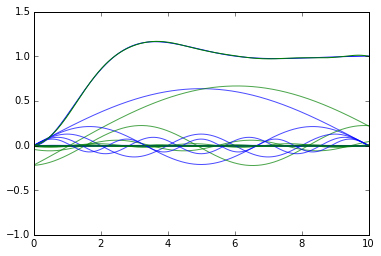

In [402]:
plt.plot(tt, gtvalues)
for unshifted, shifted in zip(sines, shiftedsines):
    plt.plot(tt, unshifted, color='blue', alpha=0.7)
    plt.plot(tt, shifted, color='green', alpha=0.7)
plt.plot(tt, sum(shiftedsines) + constant, color='green')
plt.xlim(0, t0 + P)